In [1]:
# imports
%matplotlib inline   
                     # this sets up matplotlib to make plots show up in the notebook
import numpy as np   # imports the numpy package, abbreviated as np
import matplotlib    # imports the matplotlib package for making plots
import matplotlib.pyplot as plt    # imports the part of matplotlib we use most,
 

import scipy.stats as stats
import astropy.stats as astats
import numpy.random as random
from astropy.table import Table
import pandas as pd

# Fitting for the Hubble constant with supernovae

We are continuing to work with the Hicken et al. ("Consitution") supernova dataset.  First, we read in the file into a table named `data`:

In [2]:
# CHANGE THE BELOW LINE TO POINT TO THE DIRECTORY CONTAINING SNDATA.TXT
path = './'  

# the astropy way
#data=Table.read(path+'sndata.txt',format='ascii')

# the pandas way: the file is in "fixed-width format" so we use read_fwf
data=pd.read_fwf(path+'sndata.txt')

cz=data['cz']
mu=data['mu']
sigma_mu=data['sigma_mu']
weight=1/sigma_mu**2
d = 10**(mu/5)*1E-5

logv=np.log10(cz)

# Regression with errors in the independent variable

We can use `scipy.odr` for this case.

__Note that you need to change__ 

`if 0` __to__ 

`if 1` __to get code to execute!__

Beta: [ 5.07700373 15.68526483]
Beta Std Error: [0.0703514  0.28060092]
Beta Covariance: [[ 0.00772955 -0.03079311]
 [-0.03079311  0.12296652]]
Residual Variance: 0.6403114801421016
Inverse Condition #: 0.009872856052889862
Reason(s) for Halting:
  Sum of squares convergence

slope: 5.077 +/- 0.088
intercept: 15.685 +/- 0.351
H0: 72.94 km/sec/Mpc +/- 11.83


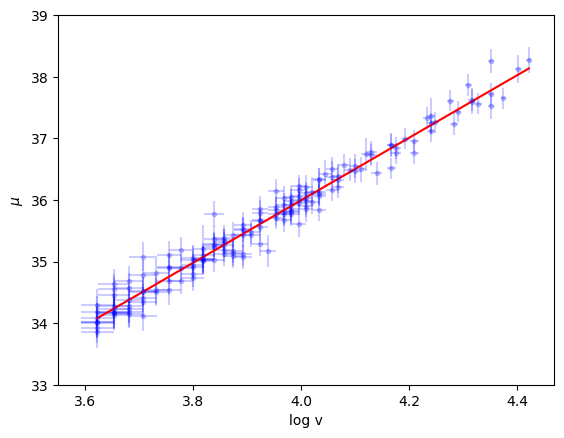

In [3]:
import scipy.odr as odr

# scipy odr package does nonlinear fitting with odr
# see https://docs.scipy.org/doc/scipy/reference/odr.html


# error due to peculiar velocities
logverr=300./(cz)/np.log(10.)

# define a linear function for the fit.  
# Note: scipy.optimize.curve_fit would similarly require us
#     to define a function whose parameters would be fit.
f = lambda beta,x: beta[0]*x+beta[1]

# define the model to fit
linear = odr.Model(f)
# define the dataset to be fit and the errors in each axis
mydata = odr.RealData(logv, mu, sx=logverr, sy=sigma_mu)

# set up the fit, including initial guesses for the parameters
myodr = odr.ODR(mydata, linear, beta0=[5., 15.])
# do the fit
myoutput = myodr.run()
# look at the results
myoutput.pprint()
slope=(myoutput.beta)[0]
intercept=(myoutput.beta)[1]
covar=myoutput.cov_beta
print()

if 1:   
    h0err = (10**(-0.2*(intercept-np.sqrt(covar[1,1]) )-np.log10(1E-5) )
              -10**(-0.2*(intercept+np.sqrt(covar[1,1]) )-np.log10(1E-5) ) ) /2.
    
    print(f'slope: {slope:.3f} +/- {np.sqrt(covar[0,0]):.3f}')
    print(f'intercept: {intercept:.3f} +/- {np.sqrt(covar[1,1]):.3f}')
    print(f'H0: {(10**(-0.2*intercept-np.log10(1E-5))):.2f} km/sec/Mpc +/- {h0err:.2f}')

    
    
    plt.errorbar(logv,mu,xerr=logverr,yerr=sigma_mu,fmt='b.',alpha=0.2)
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
    plt.plot(logv,logv*slope+intercept,'r-')

Compare results with linear regression without errors (the error goes up which is not surprising) Error increased because we propagateed the error in x in the parameters.
Do bootsrap to see what the errors really are?

# Robust regression

We can use `statsmodels` for robust regression.  Note for interpreting documentation: the 'endogenous' variable is the _dependent_ one we are fitting for, 'exogenous' variables are the _independent_ ones whose values are just provided.
First, we'll do a known case:

In [7]:
#The numpy way
coeffs = np.polyfit(logv,mu,1,w=weight)
print(f'With weights: {coeffs[0]:.4f} {coeffs[1]:.4f}')
coeffs = np.polyfit(logv,mu,1)
print(f'No weights: {coeffs[0]:.4f} {coeffs[1]:.4f}')

With weights: 5.0483 15.7979
No weights: 5.0577 15.7648


__Take a look at the documentation for sm.WLS using the below code box.__

In [17]:
?sm.WLS

Init signature: sm.WLS(endog, exog, weights=1.0, missing='none', hasconst=None, **kwargs)
Docstring:     
Weighted Least Squares

The weights are presumed to be (proportional to) the inverse of
the variance of the observations.  That is, if the variables are
to be transformed by 1/sqrt(W) you must supply weights = 1/W.

Parameters
----------
endog : array_like
    A 1-d endogenous response variable. The dependent variable.
exog : array_like
    A nobs x k array where `nobs` is the number of observations and `k`
    is the number of regressors. An intercept is not included by default
    and should be added by the user. See
    :func:`statsmodels.tools.add_constant`.
weights : array_like, optional
    A 1d array of weights.  If you supply 1/W then the variables are
    pre- multiplied by 1/sqrt(W).  If no weights are supplied the
    default value is 1 and WLS results are the same as OLS.
missing : str
    Available options are 'none', 'drop', and 'raise'. If 'none', no nan
    checking

In [8]:
#The statsmodels way
import statsmodels.api as sm
X = logv
#fit for a constant too
X = sm.add_constant(X)

# do the fit.  We could have done this in two lines as:
#model = sm.WLS(mu, X,weights=weight)
#result = model.fit()

results = sm.WLS(mu, X, weights=weight).fit()


__Now, examine the results using the below code.__  `statsmodels` provides all the info you ever wanted and more.  This is documented at https://www.statsmodels.org/0.8.0/generated/statsmodels.regression.linear_model.RegressionResults.html .

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     mu   R-squared:                       0.970
Model:                            WLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     5161.
Date:                Mon, 14 Apr 2025   Prob (F-statistic):          9.05e-125
Time:                        12:54:30   Log-Likelihood:                 50.730
No. Observations:                 164   AIC:                            -97.46
Df Residuals:                     162   BIC:                            -91.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7770      0.280     56.441      0.000      15.225      16.329
cz             5.0540      0.070     71.838      0.000       4.915       5.193
==============================================================================
Omnibus:                        4.919   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                5.038
Skew:                           0.261   Prob(JB):                       0.0806
Kurtosis:                       3.682   Cond. No.                         86.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P is the probability for the proposition if y does not depend on x

In [9]:
slope = results.params[1]
intercept = results.params[0]


# statsmodels provides multiple estimates of the standard error
err_slope=results.HC0_se[1]
err_intercept=results.HC0_se[0]

h0err = (10**(-0.2*(intercept-err_intercept) )-np.log10(1E-5) - \
    10**(-0.2*(intercept+err_intercept) )-np.log10(1E-5) )/2.

if 1:
    print(f'slope: {slope:.3f} +/- {err_slope:.3f}')
    print(f'intercept: {intercept:.3f} +/- {np.sqrt(covar[1,1]):.3f}')
    print(f'H0: {(10**(-0.2*intercept-np.log10(1E-5))):.2f} km/sec/Mpc +/- {h0err:.2f}')


slope: 5.054 +/- 0.076
intercept: 15.777 +/- 0.351
H0: 69.92 km/sec/Mpc +/- 5.00


/var/folders/9j/njs_shy50c3847zl8765jn3m0000gn/T/ipykernel_40009/366991101.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/9j/njs_shy50c3847zl8765jn3m0000gn/T/ipykernel_40009/366991101.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/9j/njs_shy50c3847zl8765jn3m0000gn/T/ipykernel_40009/366991101.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

### Applying robust fitting

__Look at the help on sm.RLM using the below code box.__  Here M denotes the function used to penalize outliers.

In [16]:
?sm.RLM

Init signature: sm.RLM(endog, exog, M=None, missing='none', **kwargs)
Docstring:     
Robust Linear Model

Estimate a robust linear model via iteratively reweighted least squares
given a robust criterion estimator.

Parameters
----------
endog : array_like
    A 1-d endogenous response variable. The dependent variable.
exog : array_like
    A nobs x k array where `nobs` is the number of observations and `k`
    is the number of regressors. An intercept is not included by default
    and should be added by the user. See
    :func:`statsmodels.tools.add_constant`.
M : statsmodels.robust.norms.RobustNorm, optional
    The robust criterion function for downweighting outliers.
    The current options are LeastSquares, HuberT, RamsayE, AndrewWave,
    TrimmedMean, Hampel, and TukeyBiweight.  The default is HuberT().
    See statsmodels.robust.norms for more information.
missing : str
    Available options are 'none', 'drop', and 'raise'. If 'none', no nan
    checking is done. If 'drop', any

In [10]:
# use a t-distribution based deweighting
rlm_model = sm.RLM(mu, X, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
print(rlm_results.params)
intercept = (rlm_results.params.iloc[0])
slope = (rlm_results.params.iloc[1])
print(f'Huber t slope, H0: {slope:.4f}, {10**(-0.2*intercept-np.log10(1E-5)):.4f}')
print()

rlm_model = sm.RLM(mu, X, M=sm.robust.norms.TrimmedMean())
rlm_results = rlm_model.fit()
#print(rlm_results.params)
intercept = (rlm_results.params.iloc[0])
slope = (rlm_results.params.iloc[1])
print(f'Trimmed mean slope, H0: {slope:.4f}, {10**(-0.2*intercept-np.log10(1E-5)):.4f}')

print()
rlm_model = sm.RLM(mu, X, M=sm.robust.norms.TukeyBiweight())
rlm_results = rlm_model.fit()
#print(rlm_results.params)
intercept = (rlm_results.params.iloc[0])
slope = (rlm_results.params.iloc[1])

print(f'Biweight slope, H0: {slope:.4f}, {10**(-0.2*intercept-np.log10(1E-5)):.4f}')



const    15.630385
cz        5.091046
dtype: float64
Huber t slope, H0: 5.0910, 74.8037

Trimmed mean slope, H0: 5.1211, 79.0722

Biweight slope, H0: 5.0930, 75.1726


In [15]:
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                     mu   No. Observations:                  164
Model:                            RLM   Df Residuals:                      162
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 14 Apr 2025                                         
Time:                        12:58:29                                         
No. Iterations:                    15                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6197      0.266     58.688      0.000      15.098      16.141
cz             5.0930      0.068     75.377      0.000       4.961       5.225
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""